### Experiment 4: Quantile prediction with Different Prior

Finally, this experiment generates Figure 8 in the paper. 

In [1]:
import sys
sys.path.append('./src')

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 3})

from BayesianQuantile import BayesianQuantilePredictor, BayesianQuantilePredictorScaled
from Baselines import EmpiricalQuantilePredictor, SingleOGD, MultiValidPrediction
import utils

T = 50
data = [0.5, 0] * int(T/2)
queried_confidence = 0.5

In [2]:
# Our algorithm. We use the inexact version with 50 bins.

myBayesian = BayesianQuantilePredictor(exact=False)
bayesian_predictions = np.zeros(T)
bayesian_loss = np.zeros(T)
for t in range(T):
    bayesian_predictions[t] = myBayesian.output(queried_confidence)
    bayesian_loss[t] = utils.quantile_loss(bayesian_predictions[t], data[t], queried_confidence)
    myBayesian.update(data[t])
bayesian_total_loss = np.cumsum(bayesian_loss)

# Using the prior Uniform([0,1/2]) rather than Uniform([0,1])

myBayesianScaled = BayesianQuantilePredictorScaled(exact=False)
bayesian_scaled_predictions = np.zeros(T)
bayesian_scaled_loss = np.zeros(T)
for t in range(T):
    bayesian_scaled_predictions[t] = myBayesianScaled.output(queried_confidence)
    bayesian_scaled_loss[t] = utils.quantile_loss(bayesian_scaled_predictions[t], data[t], queried_confidence)
    myBayesianScaled.update(data[t])
bayesian_scaled_total_loss = np.cumsum(bayesian_scaled_loss)

# ERM

myEmpirical = EmpiricalQuantilePredictor()
empirical_predictions = np.zeros(T)
empirical_loss = np.zeros(T)
for t in range(T):
    empirical_predictions[t] = myEmpirical.output(queried_confidence)
    empirical_loss[t] = utils.quantile_loss(empirical_predictions[t], data[t], queried_confidence)
    myEmpirical.update(data[t])
empirical_total_loss = np.cumsum(empirical_loss)

# OGD with a known quantile level. Here the initialization is at 0.5, and the learning rate is 1/sqrt(t)

myOGD = SingleOGD(queried_confidence)
ogd_predictions = np.zeros(T)
ogd_loss = np.zeros(T)
for t in range(T):
    ogd_predictions[t] = myOGD.output()
    ogd_loss[t] = utils.quantile_loss(ogd_predictions[t], data[t], queried_confidence)
    myOGD.update(data[t])
ogd_total_loss = np.cumsum(ogd_loss)

In [3]:
# MVP is designed for the more general group-conditional CP problem. Without covariates, we only consider a single group including all rounds. 

def all_points(x):
    return True

basic_group = [all_points]
num_groups = len(basic_group)

# MVP requires specifying the number of buckets. We use the default choice 50, which is the same as the number of bins used by our algorithm. The rest of the hyperparameters are standard.

n_buckets = 50
K_e = 2.12
eta_MVP = np.sqrt(np.log(num_groups * n_buckets) / (2 * K_e * num_groups * n_buckets))

myMVP = MultiValidPrediction(delta=1-queried_confidence, groups=basic_group, eta=eta_MVP, seed=1)
mvp_predictions = np.zeros(T)
mvp_loss = np.zeros(T)
for t in range(T):
    mvp_predictions[t] = myMVP.predict(t)
    mvp_loss[t] = utils.quantile_loss(mvp_predictions[t], data[t], queried_confidence)
    myMVP.update(x=t, threshold=mvp_predictions[t], score=data[t])
mvp_total_loss = np.cumsum(mvp_loss)

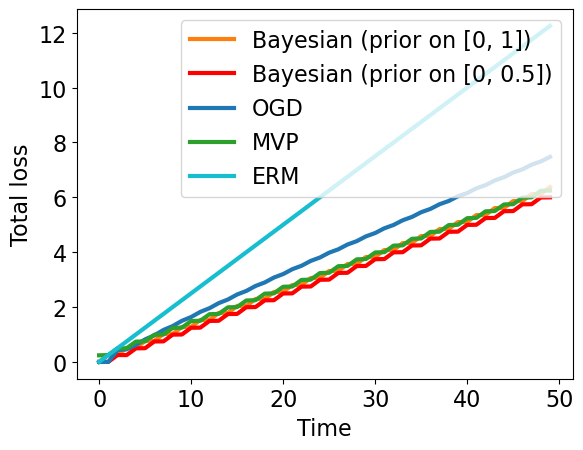

In [4]:
plt.plot(bayesian_total_loss, label='Bayesian (prior on [0, 1])', color='#ff7f0e')
plt.plot(bayesian_scaled_total_loss, label='Bayesian (prior on [0, 0.5])', color='red')
plt.plot(ogd_total_loss, label='OGD', color='#1f77b4')
plt.plot(mvp_total_loss, label='MVP', color='#2ca02c')
plt.plot(empirical_total_loss, label='ERM', color='#17becf')
plt.legend(loc="upper right")
# plt.legend(title=f'Confidence level {queried_confidence}',loc="upper right")
plt.xlabel('Time')
plt.ylabel('Total loss')

plt.savefig(f"Figures/prior.pdf", bbox_inches='tight')
plt.show()